# Text Classification with Text-Embedding and Classification Models

**Author Name:**  Dahye kim

**Last Edited:** 25 Apr 2021

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Table of Contents
* [Part 1: Text Classification](#sec_1)  
    * [1.1 Brief Inspection of the data set using `pandas`](#sec_1.1)
    * [1.2 Text Classification with Statistical Modelling: Logistic Regression using `sklearn`](#sec_1.2)
        * [1.2.1 Pre-Process Texts: Initialise 2 Configurations](#sec_1.2.1)
        * [1.2.2 Pre-process All `Abstract` Features in Each Dataset](#sec_1.2.2)
        * [1.2.3 Train and Test the Classification Model](#sec_1.2.3)
    * [1.3 Text Classification with Recurrent Neural Network: Simple RNN using `pytorch`](#sec_1.3)  
        * [1.3.1 Construct the RNN Class and Configure Relevant Functions](#sec_1.3.1)
        * [1.3.2 Train and Test the RNN Model](#sec_1.3.2)
    * [1.4 Results from Each Model and Graphical Presentation](#sec_1.4)

# Part 1:  Text Classification<a class="anchor" id="sec_1"></a>

## 1.1 Brief Inspection of the data set using `pandas` <a class="anchor" id="sec_1.1"></a>

In [2]:
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
# nltk tokenizers and lemmatisers for text pre-processing configuration

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import * 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import precision_recall_curve
# statistical modelling using sklearn 
# evaluatation metrics for classifiers from sklearn 

import pandas as pd 
import numpy as np

In [3]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
targets = ['InfoTheory','CompVis','Math']
feature = ['Abstract']

**Append train and test data to one single dataframe for a brief EDA**

In [5]:
trainWhole = pd.read_csv('./axcs_train.csv')
# reading in the entire data set 
test = pd.read_csv('./axcs_test.csv').loc[:, targets + feature]
# reading in the test data set with only target and features 
train = trainWhole.loc[:, targets+feature]
# select only the target and features attributes from the training set 
trainPartial = trainWhole.loc[:999,:]
# first 1000 observations 
trainPartial = trainPartial.loc[:, targets + feature]
# select only the features and target for the train set with first 1000 observations 
trainPartial.to_csv('./axcs_train_1000.csv', index = False)
# export the data set with 1000 observations for RNN model in part 1.3
datasets = [train, test, trainPartial]

In [6]:
dfs = []
for df in datasets: 
    temp = pd.concat([pd.DataFrame(df[i].value_counts()).T for i in targets])
    temp['Null Accuracy'] = temp[0]/(temp[0]+temp[1])
    temp['Target'] = temp.index.tolist()
    dfs.append(temp)

**Inspecting Class Imbalance and Null Accuracy before building a Model**

In [7]:
trainWholeClass = dfs[0]
trainPartialClass = dfs[2]
testClass = dfs[1]

In [8]:
trainWholeClass

,0,1,Null Accuracy,Target
InfoTheory,44193,10538,0.807458,InfoTheory
CompVis,52507,2224,0.959365,CompVis
Math,38004,16727,0.694378,Math


In [9]:
trainWhole[targets].value_counts()

InfoTheory  CompVis  Math
0           0        0       35916
1           0        1       10538
0           0        1        6053
            1        0        2088
                     1         136
dtype: int64

In [10]:
trainPartialClass

,0,1,Null Accuracy,Target
InfoTheory,998,2,0.998,InfoTheory
CompVis,999,1,0.999,CompVis
Math,976,24,0.976,Math


In [11]:
trainPartial[targets].value_counts()

InfoTheory  CompVis  Math
0           0        0       975
                     1        22
1           0        1         2
0           1        0         1
dtype: int64

In [12]:
testClass

,0,1,Null Accuracy,Target
InfoTheory,16062,3616,0.816241,InfoTheory
CompVis,17526,2152,0.890639,CompVis
Math,13748,5930,0.698648,Math


Each target on the test set is also severely imbalanced. The attribute `Null Accuracy` refers to the proportion of class 0 of each target. The worst performance of a classifier can be demonstrated by an accuracy equal to the `Null Accuracy`. 

## 1.2. Text Classification with Statistical Modelling: Logistic Regression using `sklearn`<a class="anchor" id="sec_1.2"></a>

### 1.2.1 Pre-Process Texts: Initialise 2 Configurations<a class="anchor" id="sec_1.2.1"></a>

In [13]:
stopword = set(stopwords.words('english'))
# create stopwords list 

In [14]:
# TextPreprocessing_1 
class RegexSNBTokenizer(object): 
    def __init__(self): 
        self.snb = SnowballStemmer('english')
        self.tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
        self.__name__ = 'Regex_SNB'
        # initialise stemmer and tokenizer 
        # create .__name__ for latter use 
        
    def __call__(self, doc): 
        
        return [t.lower() for t in \
                [self.snb.stem(token) for token in self.tokenizer.tokenize(doc) \
                 if token not in stopword] \
                if len(t)>1
                # tokenize each word first, and stem it using snowball stemmer 
                # then from the list of tokens, filter out stopwords, tokens with length less than 1
                # change all the rest of the tokens into lower case 
               ]

In [15]:
vectorizerRegexSNBTokenizer = TfidfVectorizer(analyzer = 'word',\
                            input = 'content',\
                            ngram_range = (1,1),\
                            tokenizer = RegexSNBTokenizer())
# tf-idf vectoriser for classification 
# use only unigrams 

In [16]:
class WordPunktLemmatizer(object): 
    def __init__(self): 
        self.wn = WordNetLemmatizer()
        self.wp = WordPunctTokenizer()
        self.__name__ = 'WordPunct_WordNet'
        # initliase lemmatizer and tokenizer
    def __call__(self, doc): 
        return [t.lower() for t in \
                [self.wn.lemmatize(token) for token in self.wp.tokenize(doc) \
                 if token not in stopword]]
        # tokenize each word and lemmatize them 
        # filter out stopwords and change to lower case 

In [17]:
vectorizerWordPunktLemmatizer = TfidfVectorizer(analyzer = 'word',\
                            input = 'content',\
                            ngram_range = (1,2),\
                            tokenizer = WordPunktLemmatizer())
# tf-idf vectoriser for classification
# use both bigrams and unigrams 

### 1.2.2. Pre-process All `Abstract` Features in Each Dataset<a class="anchor" id="sec_1.2.2"></a>

In [18]:
textPreProcessing = [vectorizerRegexSNBTokenizer, vectorizerWordPunktLemmatizer]
# put all the tf-idf vectorizers into a list for looping 
trainSet = [train, trainPartial]
# put all the training data into a list for looping 
testDocs = test['Abstract'].tolist()
# put all the texts of test data into a list for pre-processing 

In [19]:
trainFeatures = dict()
# the dictionary holds converted texts of both train sets and the test dataset 

for train in trainSet: 
# loop through each training dataset 
    
    trainDoc = train['Abstract'].tolist()
    # convert the pandas series object into a list for conversion 

    if len(trainDoc) == 1000: size = 'Partial'
    else: size = 'Whole'
    # differentiate train data sets based on the size of the data aset 
        
    for eachPreProcessing in textPreProcessing: 
        trainFeatures[f'{size} - {eachPreProcessing.tokenizer.__name__}'] = \
        [eachPreProcessing.fit_transform(trainDoc),\
         eachPreProcessing.transform(testDocs)]
        # fit and transform the training data with tf-idf vectoriser 
        # transform the test data with the trained tf-idf vectoriser 
        # store them both into a list in order to fit them into the classifer 

In [20]:
trainFeatures.keys()
# each train-test tf-idf vectors are stored into the dictionary with 
# respective keys 

dict_keys(['Whole - Regex_SNB', 'Whole - WordPunct_WordNet', 'Partial - Regex_SNB', 'Partial - WordPunct_WordNet'])

### 1.2.3. Train and Test the Classification Model<a class="anchor" id="sec_1.2.3"></a>

In [21]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
# initialise logistic regression model 

In [22]:
metrics_lr = pd.DataFrame(columns = ['Config','Target','Model',\
                                  'Accuracy','Precision','Recall','F-1'],\
                       index=[*range(3*2*2)])
# there are 12 logistic regression models in total 
# the evaluation metrics of each model will be stored in a data frame 
precisionRecall_lr = dict() 
# precisino-recall curve object of each model is stored into a dictionary 

In [23]:
n = 0
# index of each model for metrics_lr data frame 

for key in trainFeatures.keys(): 
# loop through each predictor in the dictionary 

    xTrain = trainFeatures[key][0]
    # training predictor to fit into the model 
    xTest = trainFeatures[key][1]
    # test predictor for prediction

    for targetName in targets: 
    # loop through each target (topic)
        if key.startswith('Whole'):
        # the keys of entire training data set starts with 'Whole'
            target = np.asarray(trainSet[0][targetName])
            # the target from  the entire dataset 
            
        else: target = np.asarray(trainSet[1][targetName])
        # if the key does not start with 'Whole', then the data size is 1000 
        # the target is the class from the first 1000 observations 

        lr.fit(xTrain, target)
        # fit the predictor and target into the logistic regression model 
        predictLabel = lr.predict(xTest)
        # predict the target using the test set 
        testLabel = np.asarray(test[targetName])
        # convert the true values to numpy array for calculating evaluation metrics 

        metrics_lr.iloc[n,:] = [key,targetName,\
                                'LogisticRegression',\
                                accuracy_score(testLabel, predictLabel),\
                                precision_score(testLabel, predictLabel, average = 'macro'),\
                                recall_score(testLabel, predictLabel, average = 'macro'),\
                                f1_score(testLabel, predictLabel, average = 'macro')]
        # the metric_lr data frame stores th accuracy, precision, recall, and f1 score of the classifier 
        # these are calculated using the predicted and the truth values 
        # the name of the topic(target) is also saved for the data frame 
            
        precisionRecall_lr[n] = [precision_recall_curve(testLabel, predictLabel)]
        # precision-recall curve of the model is stored into a dictionary 
        # the key is the respective row index in metrics_lr 
            
        n+=1
        # increment the row index of metrics_lr by 1 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

## 1.3 Text Classification with Recurrent Neural Network: Simple RNN using `pytorch`<a class="anchor" id="sec_1.3"></a>

Before developing and training an RNN model, I need to first define the RNN class and create some functions for training, validating, and testing.
For `pytorch`, `DataField` needs to be defined when reading in training and testing data sets. The `DataField` is similar to data schema for databases, where the data structure and function of each attribute in a model (e.g. feature or target) will be specified. 

In [ ]:
import torch
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset
import torch.optim as optim
import torch.nn as nn

### 1.3.1 Construct the RNN Class and Configure Relevant Functions<a class="anchor" id="sec_1.3.1"></a>

In [25]:
# Define Rnn class for simple RNN model 
class Rnn(nn.Module): 
    def __init__(self, inputDimension, embeddingDimension, hiddenDimension, outputDimension): 
        super().__init__()
        # inherit all the traits from nn.Module
        self.embedding = nn.Embedding(inputDimension, embeddingDimension)
        # text embedding layer
        self.rnn = nn.RNN(embeddingDimension, hiddenDimension)
        # rnn model with 1 hidden dimension 
        self.fc = nn.Linear(hiddenDimension, outputDimension)
        
    def forward(self, text): 
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        # output is the list of all the hidden layers 
        # hidden is the last hidden stage of the model 
        
        assert torch.equal(output[-1, :, :], hidden.squeeze(0))
        return self.fc(hidden.squeeze(0))

In [26]:
def binaryAccuracy(preds, y): 
# The function for calculating the accuracy of each batch of train set 
    roundedPrediction = torch.round(torch.sigmoid(preds))
    correct = (roundedPrediction == y).float()
    accuracy = correct.sum()/len(correct)
    return accuracy

In [27]:
def training(model, iterator, optimizer, criterion): 
# training function for RNN model 
    
    epochLoss = 0 
    epochAccuracy = 0 
    # calculate the loss and accuracy of each epoch 
    
    model.train() 
    # set torch into training mode 
    
    for batch in iterator: 
    # loop through each batch of the iterator input 
        optimizer.zero_grad()
        # set the gradient to 0 
        predictions = model(batch.Abstract).squeeze(1) 
        # predict using the model, forward prop
        loss = criterion(predictions, batch.label)
        # calculate the loss of each batch with specified criterion 
        accuracy = binaryAccuracy(predictions, batch.label)
        # calculate the accuracy of each batch 
        
        loss.backward()
        optimizer.step() 
        # backward prop
        
        epochLoss += loss.item()
        epochAccuracy += accuracy.item()
        # loss and accuracy of each batch accumulated 
        
    return epochLoss/len(iterator), epochAccuracy/len(iterator)
    # return training loss and accuracies 

In [28]:
def evaluate(model, iterator, criterion): 
    
    epochLoss = 0 
    epochAccuracy = 0 
    # loss and accuracy of each epoch 

    model.eval()
    # setting torch to evaluation mode 
    # only forward propagation needed 
    
    with torch.no_grad(): 
    # no paramter optimisation (backward propagation) needed 
        for batch in iterator: 
            # loop through each batch in the iterator 
            predictions = model(batch.Abstract).squeeze(1)
            loss = criterion(predictions, batch.label)
            accuracy = binaryAccuracy(predictions, batch.label)
            # calculate the loss and accuracy of each batch 

            epochLoss += loss.item()
            epochAccuracy += accuracy.item()
            # validation accuracy and loss accummulated 
            
    return epochLoss/len(iterator), epochAccuracy/len(iterator)
    # return validation loss and accuracy 

In [29]:
def predict(model, iterator, criterion): 

    yTest = []
    yPredict = []
    # store the predicted labels and truth values 
    
    model.eval()
    # set torch to evaluation mode 
    
    with torch.no_grad(): 
        for batch in iterator: 
            predictions = model(batch.Abstract).squeeze(1)
            rounded_preds = torch.round(torch.sigmoid(predictions))
            yPredict += rounded_preds.tolist()
            yTest += batch.label.tolist()
            # predict the label using the model and add them into yPredict list 
            # truth label is also stored in the yTest list 
            
    return np.asarray(yTest), np.asarray(yPredict)
    # return the truth and predict labels, both as numpy arrays for metric calculations

### 1.3.2. Train and Test the RNN Model<a class="anchor" id="sec_1.3.2"></a>

In [30]:
LABEL = data.LabelField(dtype = torch.float, \
                        use_vocab=False, \
                        preprocessing=int)
# the target variable Field specification 
# the target is a binary integer, and the data type is in torch 

In [31]:
metrics_rnn = pd.DataFrame(columns = ['Config','Target','Model',\
                                  'Accuracy','Precision','Recall','F-1'],\
                       index=[*range(3*2*2)])
# evaluation metrics data frame will be filled from each model after training 

In [32]:
tokenizers = [RegexSNBTokenizer(), WordPunktLemmatizer()]
# put tokenizers into a list for looping through 
precisionRecall_rnn = dict() 
# store the precision-recall curve object to a dictionary 

In [33]:
n = 0
# index of each model for metrics data frame and precision recall cuve 
epochs = 5
# each model runs for 5 epochs 

for eachTokenizer in tokenizers: 
# for each text pre-processing configuration 
    
    tokenizer = eachTokenizer.__name__
    # name of each tokenizer extracted 
    
    TEXT = data.Field(sequential = True,\
                     tokenize = eachTokenizer,\
                     lower = True)
    # data.field for text is established using text pre-processing configuration 
    dataFields = {'Abstract': ('Abstract', TEXT)}
    # the column named 'Abstract' will be configured with TEXT data.Field 
    
    for targetName in targets:
    # for each target
        
        dataFields[targetName] = ('label', LABEL)
        # each target will be configured with LABEL data.Field, and it'll be renamed as 'label' 
        
        train1, train2, test = data.TabularDataset.splits(path = './', \
                                   train = 'axcs_train.csv',\
                                         format = 'csv', \
                                         fields = dataFields,\
                                         validation = 'axcs_train_1000.csv',\
                                        test = 'axcs_test.csv',\
                                        skip_header = False)
        # loading in each train data set and the test set with respective field schema 
          
        trainSets = [train1, train2]
        # put train set into a list for looping 

        del dataFields[targetName]
        # for the next topic at next loop, the name of the target in the current loop is deleted
        
        for eachTrainSet in trainSets: 
        # loop through each train set 
            
            if len(eachTrainSet) == 1000: 
                maxVocabSize = 3000 
                batchSize = 16
                embeddingDimension = 100
                size = 'Partial'

            else: 
                maxVocabSize = 5500
                batchSize = 64
                embeddingDimension = 200
                size = 'Whole'
            # different number of observations in each training set have differnt RNN configuration

            train, valid = eachTrainSet.split(split_ratio = 0.7)
            # split the training and validation data set 
            # 0.7 for training, 0.3 for validation 
                
            TEXT.build_vocab(eachTrainSet, max_size = maxVocabSize)
            # build vocab with each train set with respective maxVocabSize 
            
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            
            trainIt, validIt, testIt = data.BucketIterator.splits((train, valid, test),\
                                            batch_size = batchSize,\
                                            device = device,\
                                            sort_key = lambda x: len(x.Abstract),\
                                            sort_within_batch = False)
            # create iterator of train, validation, and test set with respective batch size 
            # all iterators are saved into cuda 

            inputDimension = len(TEXT.vocab)
            hiddenDimension = 256 
            outputDimension = 1
            # the first dimension of RNN is the vocab size 
            # hidden dimension is all set at 256 
            # output dimension is a binary digit 
            
            model = Rnn(inputDimension, embeddingDimension, hiddenDimension, outputDimension).to(device)
            # configure model with respective hyperparameters 
            optimizer = optim.SGD(model.parameters(), lr = 1e-3)
            # stochastic gradient decent as the optimiser for backward propagation
            criterion = nn.BCEWithLogitsLoss().to(device)
            # binary cross entropy for calculating loss 
            # save the output to cuda 

            print(f'\nText Pre-Processing Configuration: {eachTokenizer.__name__}')
            print(f'Data Size: {len(eachTrainSet)}')
            print(f'Target: {targetName}')

            bestValidLoss = float('inf')
            # unbounded upper value for validation loss 
            bestModel = None

            for epoch in range(epochs): 
            # for each epoch 
            
                trainLoss, trainAccuracy = training(model, trainIt, optimizer, criterion)
                # train the model and calculate training loss and training accuracy of each epoch
                validLoss, validAccuracy = evaluate(model, validIt, criterion)
                # validate the model and calculate validation loss and accuracy of each epoch 
                # optimiser is omitted since backward propagation for optimisation is not needed for validation 

                if validLoss < bestValidLoss: 
                    bestValidLoss = validLoss 
                    bestModel = model
                    # the best model has the least validation loss 

                print('------------------------------------------------')
                print(f'Epoch {epoch}:')
                print(f'\tTrain Loss: {trainLoss:.3f} | Train Acc: {trainAccuracy*100:.2f}%')
                print(f'\t Val. Loss: {validLoss:.3f} |  Val. Acc: {validAccuracy*100:.2f}%')
          
            
            truth, pred = predict(bestModel, testIt, criterion)
            # using the best model and predict the label using test iterator 
            # truth and pred are numpy arrays returned by predict function
            metrics_rnn.iloc[n,:] = [f'{size} - {tokenizer}',\
                                targetName,\
                                'RNN',\
                                accuracy_score(truth,pred),\
                                precision_score(truth,pred,average='macro'),\
                                recall_score(truth,pred,average='macro'),\
                                f1_score(truth,pred,average='macro')]
            # calculate the evaluation metrics for each model and save them to data frame

            precisionRecall_rnn[n] = [precision_recall_curve(truth, pred)]
            # precision and recall curve object is saved to the dictionary
            # the key is the data frame index 

            n += 1
            # increment the model index by 1



Text Pre-Processing Configuration: Regex_SNB
Data Size: 54731
Target: InfoTheory
------------------------------------------------
Epoch 0:
	Train Loss: 0.505 | Train Acc: 79.25%
	 Val. Loss: 0.638 |  Val. Acc: 61.12%
------------------------------------------------
Epoch 1:
	Train Loss: 0.495 | Train Acc: 80.21%
	 Val. Loss: 0.636 |  Val. Acc: 61.81%
------------------------------------------------
Epoch 2:
	Train Loss: 0.494 | Train Acc: 80.20%
	 Val. Loss: 0.634 |  Val. Acc: 62.60%
------------------------------------------------
Epoch 3:
	Train Loss: 0.495 | Train Acc: 80.21%
	 Val. Loss: 0.632 |  Val. Acc: 63.18%
------------------------------------------------
Epoch 4:
	Train Loss: 0.495 | Train Acc: 80.21%
	 Val. Loss: 0.631 |  Val. Acc: 63.58%

Text Pre-Processing Configuration: Regex_SNB
Data Size: 1000
Target: InfoTheory
------------------------------------------------
Epoch 0:
	Train Loss: 0.377 | Train Acc: 96.73%
	 Val. Loss: 0.303 |  Val. Acc: 94.63%
---------------------

## 1.4 Results from Each Model and Graphical Presentation<a class="anchor" id="sec_1.4"></a>
* [1.4.1 Sample Size & Model Performance](#sec_1.4.1)
* [1.4.2 Text Pre-Processing & Model Performance](#sec_1.4.2)
* [1.4.3. Algorithm & Model Performance](#sec_1.4.3)
* [1.4.4. Precision-Recall Curves](#sec_1.4.4)

In [34]:
import matplotlib 
import matplotlib.pyplot as plt

In [35]:
metrics = pd.concat([metrics_lr, metrics_rnn])

In [36]:
metrics = metrics.merge(testClass.loc[:,['Target', 'Null Accuracy']],\
              on = 'Target')
metrics = metrics[['Config', 'Target', 'Model', 'Null Accuracy',\
                   'Accuracy', 'Precision', 'Recall', 'F-1']]\
                   .sort_values(by = ['Model','Config', 'Target'])\
                   .reset_index(drop = True)

In [37]:
metrics

,Config,Target,Model,Null Accuracy,Accuracy,Precision,Recall,F-1
0,Partial - Regex_SNB,CompVis,LogisticRegression,0.890639,0.890639,0.44532,0.5,0.471078
1,Partial - Regex_SNB,InfoTheory,LogisticRegression,0.816241,0.816241,0.408121,0.5,0.449412
2,Partial - Regex_SNB,Math,LogisticRegression,0.698648,0.698648,0.349324,0.5,0.411297
3,Partial - WordPunct_WordNet,CompVis,LogisticRegression,0.890639,0.890639,0.44532,0.5,0.471078
4,Partial - WordPunct_WordNet,InfoTheory,LogisticRegression,0.816241,0.816241,0.408121,0.5,0.449412
5,Partial - WordPunct_WordNet,Math,LogisticRegression,0.698648,0.698648,0.349324,0.5,0.411297
6,Whole - Regex_SNB,CompVis,LogisticRegression,0.890639,0.959701,0.95539,0.831039,0.880588
7,Whole - Regex_SNB,InfoTheory,LogisticRegression,0.816241,0.947657,0.941885,0.878792,0.906225
8,Whole - Regex_SNB,Math,LogisticRegression,0.698648,0.871278,0.85994,0.825934,0.839976
9,Whole - WordPunct_WordNet,CompVis,LogisticRegression,0.890639,0.955991,0.953942,0.812855,0.866813


### 1.4.1 Sample Size & Model Performance<a class="anchor" id="sec_1.4.1"></a>

In [38]:
metrics_ = metrics.copy()

In [39]:
metrics_.sort_values(by = ['Config', 'Model', 'Target'], inplace = True)
# sort values based on the configuration, which contain information on sample size 
metrics_.reset_index(drop = True, inplace = True)
metrics__lr = metrics_.iloc[:12, :]
metrics__rnn = metrics_.iloc[12:, :]
# segregate logistic regression and rnn models 

In [40]:
label_1 = (metrics__lr.Config+'_'+metrics__lr.Model+'_'+metrics__lr.Target).tolist()
label_1 = [i.split(' - ')[1] for i in label_1]

label_2 = (metrics__rnn.Config+'_'+metrics__rnn.Model+'_'+metrics__rnn.Target).tolist()
label_2 = [i.split(' - ')[1] for i in label_2]
# labels on the y-axis for group bar plot

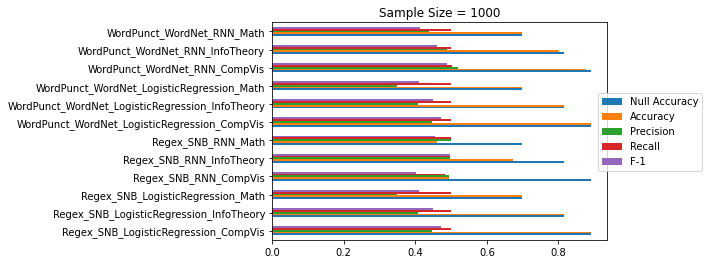

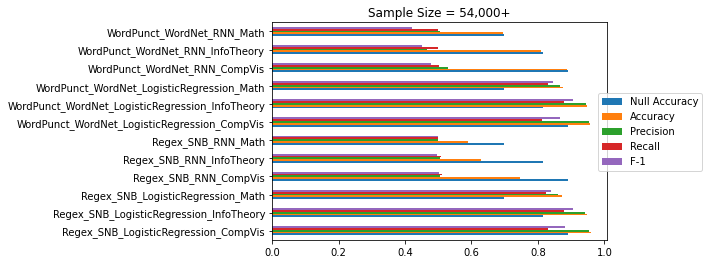

In [41]:
ax = metrics__lr.plot.barh()
ax.legend(bbox_to_anchor=(1.3, 0.7))
ticks = label_1
ax.set_title('Sample Size = 1000')
ax.set_yticklabels(ticks);

ax2 = metrics__rnn.plot.barh()
ax2.legend(bbox_to_anchor=(1.3, 0.7))
ticks = label_2
ax2.set_title('Sample Size = 54,000+')
ax2.set_yticklabels(ticks);

### 1.4.2. Text Pre-Processing & Model Performance<a class="anchor" id="sec_1.4.2"></a>

In [42]:
metrics_ = metrics.copy()

In [43]:
metrics_['TokenizerStemmer'] = metrics_['Config'].apply(lambda x: x.split(' - ')[1])
metrics_['SampleSize'] = metrics_['Config'].apply(lambda x: x.split(' - ')[0])
metrics_['Config'] = metrics_.Model\
+ '_' + metrics_.Target + '_' + metrics_.SampleSize
# rename the configuration for comparing models based on text pre-processing 
metrics_ = metrics_[['Config','TokenizerStemmer', 'SampleSize', 'Target', 'Model',\
                  'Accuracy', 'Precision', 'Recall', 'F-1']]\
.sort_values(by = ['TokenizerStemmer', 'Model','SampleSize', 'Target'])

In [44]:
temp_1 = metrics_.iloc[:12, :]
temp_2 = metrics_.iloc[12:, :]
label_1 = (temp_1.Config).tolist()
label_2 = (temp_2.Config).tolist()
# labels for y-axis 

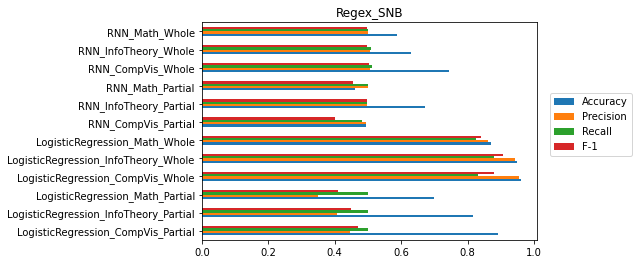

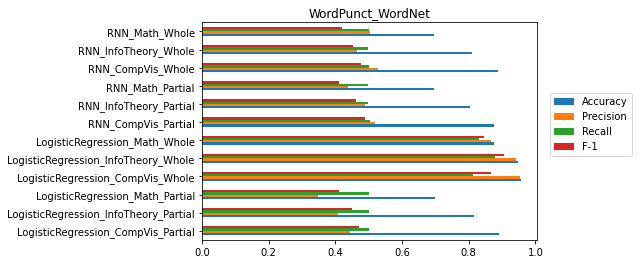

In [45]:
ax = temp_1.plot.barh()
ax.legend(bbox_to_anchor=(1.3, 0.7))
ticks = label_1
ax.set_title('Regex_SNB')
ax.set_yticklabels(ticks);

ax2 = temp_2.plot.barh()
ax2.legend(bbox_to_anchor=(1.3, 0.7))
ticks = label_2
ax2.set_title('WordPunct_WordNet')
ax2.set_yticklabels(ticks);

### 1.4.3. Algorithm & Model Performance<a class="anchor" id="sec_1.4.3"></a>

In [46]:
metrics_ = metrics.copy()
metrics_['TokenizerStemmer'] = metrics_['Config'].apply(lambda x: x.split(' - ')[1])
metrics_['SampleSize'] = metrics_['Config'].apply(lambda x: x.split(' - ')[0])
metrics_['Config'] = metrics_.Model\
+ '_' + metrics_.Target + '_' + metrics_.SampleSize
# rename the configurations to compare models based on model algorithm
metrics_ = metrics_[['Config','TokenizerStemmer', 'SampleSize', 'Target', 'Model',\
                  'Accuracy', 'Precision', 'Recall', 'F-1']]\
.sort_values(by = ['Model', 'SampleSize','TokenizerStemmer', 'Target'])

In [47]:
temp_1 = metrics_.iloc[:12, :]
temp_2 = metrics_.iloc[12:, :]

label_1 = (temp_1.Config).tolist()
label_2 = (temp_2.Config).tolist()

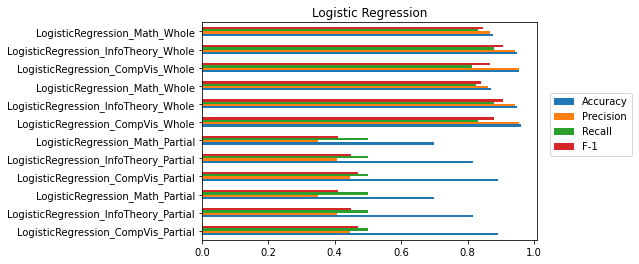

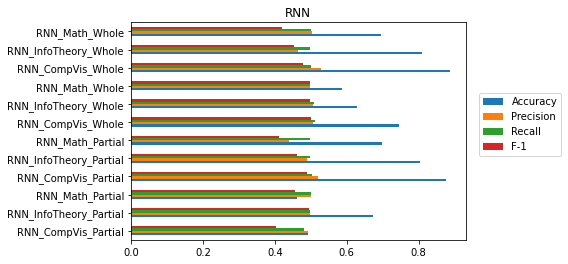

In [48]:
ax = temp_1.plot.barh()
ax.legend(bbox_to_anchor=(1.3, 0.7))
ticks = label_1
ax.set_title('Logistic Regression')
ax.set_yticklabels(ticks);

ax2 = temp_2.plot.barh()
ax2.legend(bbox_to_anchor=(1.3, 0.7))
ticks = label_2
ax2.set_title('RNN')
ax2.set_yticklabels(ticks);

### 1.4.4. Precision-Recall Curves<a class="anchor" id="sec_1.4.4"></a>

In [49]:
test = pd.read_csv('./axcs_test.csv').loc[:, targets + feature]
testClassRatio = pd.concat([pd.DataFrame(test[i].value_counts()).T for i in targets])
testClassRatio['Null Precision'] = testClassRatio[1]/(testClassRatio[0]+testClassRatio[1])
testClassRatio['Null Accuracy'] = testClassRatio[0]/(testClassRatio[0]+testClassRatio[1])
testClassRatio['Target'] = testClassRatio.index.tolist()
# calculating null precision and null accuracy of each class 
# null accuracy is the proportion of the larger number of class in the target 

In [50]:
metrics_lr= metrics_lr.merge(testClassRatio[['Target', 'Null Precision']], on = 'Target')

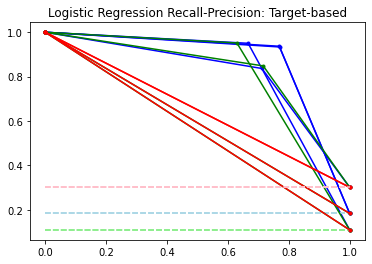

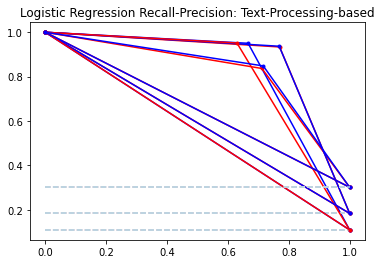

In [51]:
for key in list(precisionRecall_lr.keys())[:12]: 
    
    config = metrics_lr.loc[key, 'Config']
    target = metrics_lr.loc[key, 'Target']
    noSkill = metrics_lr.loc[key, 'Null Precision']
    
    if target == 'Math': 
        col = 'red'
        nullCol = 'pink'
    elif target == 'CompVis': 
        col = 'green'
        nullCol = 'lightgreen'
    else: 
        col = 'blue'
        nullCol = 'lightblue' 

    plot1 = plt.figure(1)    
    plt.plot(precisionRecall_lr[key][0][1], \
             precisionRecall_lr[key][0][0], \
             marker = '.',\
               label = f'{config}\n{target}', \
             color = col)
    
    plt.plot([0, 1], [noSkill, noSkill], \
             linestyle='--', \
             label=f'{config}\n{target}: No Skill',\
            color = nullCol)
    plt.title('Logistic Regression Recall-Precision: Target-based')

    plot2 = plt.figure(2)
    if config.endswith('SNB'): 
      col = 'red'
      nullCol = 'pink'
    else: 
      col = 'blue'
      nullCol = 'lightblue'
    plt.plot(precisionRecall_lr[key][0][1], \
             precisionRecall_lr[key][0][0], \
             marker = '.',\
               label = f'{config}\n{target}', \
             color = col)
    
    plt.plot([0, 1], [noSkill, noSkill], \
             linestyle='--', \
             label=f'{config}\n{target}: No Skill',\
            color = nullCol)
    plt.title('Logistic Regression Recall-Precision: Text-Processing-based')

In [52]:
metrics_rnn= metrics_rnn.merge(testClassRatio[['Target', 'Null Precision']], on = 'Target')

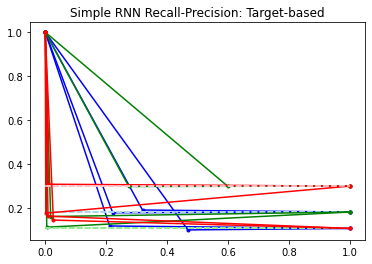

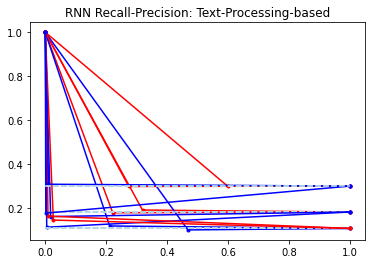

In [53]:
for key in list(precisionRecall_rnn.keys()): 
    
    config = metrics_rnn.loc[key, 'Config']
    target = metrics_rnn.loc[key, 'Target']
    noSkill = metrics_rnn.loc[key, 'Null Precision']
    
    if target == 'Math': 
        col = 'red'
        nullCol = 'pink'
    elif target == 'CompVis': 
        col = 'green'
        nullCol = 'lightgreen'
    else: 
        col = 'blue'
        nullCol = 'lightblue' 

    plot1 = plt.figure(1)       
    plt.plot(precisionRecall_rnn[key][0][1], \
             precisionRecall_rnn[key][0][0], \
             marker = '.',\
               label = f'{config}\n{target}', \
             color = col)
    
    plt.plot([0, 1], [noSkill, noSkill], \
             linestyle='--', \
             label=f'{config}\n{target}: No Skill',\
            color = nullCol)
    plt.title('Simple RNN Recall-Precision: Target-based')

    plot2 = plt.figure(2)
    if config.endswith('SNB'): 
      col = 'red'
      nullCol = 'pink'
    else: 
      col = 'blue'
      nullCol = 'lightblue'
    plt.plot(precisionRecall_rnn[key][0][1], \
             precisionRecall_rnn[key][0][0], \
             marker = '.',\
               label = f'{config}\n{target}', \
             color = col)
    
    plt.plot([0, 1], [noSkill, noSkill], \
             linestyle='--', \
             label=f'{config}\n{target}: No Skill',\
            color = nullCol)
    plt.title('RNN Recall-Precision: Text-Processing-based')